In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import joblib
import os

SEED = 42
np.random.seed(SEED)

# Modelado y evaluación

In [4]:
train_path = "train_balanceado.csv"
val_path   = "val.csv"
test_path  = "test.csv"

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)
test_df  = pd.read_csv(test_path)

print("Tamaños -> train:", len(train_df), "| val:", len(val_df), "| test:", len(test_df))
train_df.head(3)

Tamaños -> train: 1059 | val: 243 | test: 485


,texto_clean,ods
0,gracias avances clinicos salud publica han red...,3
1,otras dimensiones relevantes incluyen sexo jef...,1
2,deciden cobrar derecho paquete social cubre se...,1


## Vectorización de texto

In [33]:
vectorizador = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)

X_train = vectorizador.fit_transform(train_df["texto_clean"])
y_train = train_df["ods"].values

X_val   = vectorizador.transform(val_df["texto_clean"])
y_val   = val_df["ods"].values

X_test  = vectorizador.transform(test_df["texto_clean"])
y_test  = test_df["ods"].values

X_train.shape, X_val.shape, X_test.shape

((1059, 8869), (243, 8869), (485, 8869))

Resultado: Se convierte el texto limpio en representaciones numéricas utilizando TF-IDF con n-gramas (1,2). Esto permite usar los datos en los algoritmos de machine learning.

## Función de métricas

In [36]:
def resumen_metricas(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    return {
        "accuracy": acc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f1_macro,
        "precision_weighted": p_w,
        "recall_weighted": r_w,
        "f1_weighted": f1_w,
    }

Resultado: Se define una función que calcula varias métricas de desempeño:  accuracy, precision, recall y F1 (macro y weighted).

## Función para imprimir resumen

In [37]:
def imprimir_resumen(nombre, y_true_val, y_pred_val, y_true_test, y_pred_test):
    m_val  = resumen_metricas(y_true_val,  y_pred_val)
    m_test = resumen_metricas(y_true_test, y_pred_test)
    print(nombre)
    print("Validación:", {k: round(v,3) for k,v in m_val.items()})
    print("Test      :", {k: round(v,3) for k,v in m_test.items()})
    return m_val, m_test

Se crea una función auxiliar que muestra las métricas en validación y test para un modelo dado.

## Función para matriz de confusión

In [38]:
def plot_confusion(y_true, y_pred, titulo="Matriz de confusión (test)"):
    cm = confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_true)))
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(titulo)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Verdadero")
    ax.set_xticks(range(len(cm))); ax.set_yticks(range(len(cm)))
    ax.set_xticklabels(sorted(np.unique(y_true))); ax.set_yticklabels(sorted(np.unique(y_true)))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()

Se define una función que grafica la matriz de confusión, mostrando predicciones vs valores reales.

## Modelo 1: Naive Bayes Multinomial

Naive Bayes Multinomial
Validación: {'accuracy': 0.963, 'precision_macro': 0.953, 'recall_macro': 0.966, 'f1_macro': 0.959, 'precision_weighted': 0.965, 'recall_weighted': 0.963, 'f1_weighted': 0.963}
Test      : {'accuracy': 0.946, 'precision_macro': 0.936, 'recall_macro': 0.944, 'f1_macro': 0.939, 'precision_weighted': 0.948, 'recall_weighted': 0.946, 'f1_weighted': 0.947}


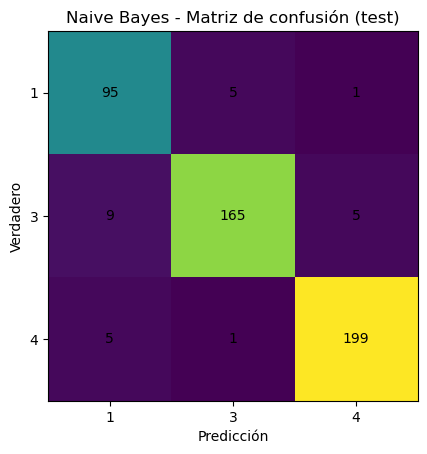

In [39]:

nb = MultinomialNB()
nb.fit(X_train, y_train)

pred_val  = nb.predict(X_val)
pred_test = nb.predict(X_test)

m_nb_val, m_nb_test = imprimir_resumen("Naive Bayes Multinomial", y_val, pred_val, y_test, pred_test)
plot_confusion(y_test, pred_test, "Naive Bayes - Matriz de confusión (test)")


Se entrena un modelo de **Naive Bayes Multinomial** con los datos vectorizados.  
Se evalúa en validación y test, mostrando métricas y matriz de confusión.

## Modelo 2: Regresión Logística

Regresión Logística
Validación: {'accuracy': 0.975, 'precision_macro': 0.968, 'recall_macro': 0.977, 'f1_macro': 0.972, 'precision_weighted': 0.976, 'recall_weighted': 0.975, 'f1_weighted': 0.975}
Test      : {'accuracy': 0.967, 'precision_macro': 0.965, 'recall_macro': 0.965, 'f1_macro': 0.965, 'precision_weighted': 0.967, 'recall_weighted': 0.967, 'f1_weighted': 0.967}


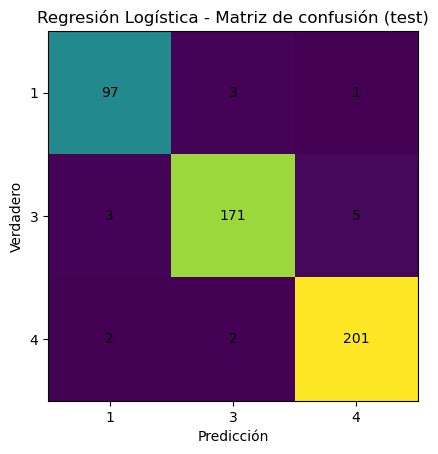

In [41]:
lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced", 
    n_jobs=-1                
)
lr.fit(X_train, y_train)

pred_val  = lr.predict(X_val)
pred_test = lr.predict(X_test)

m_lr_val, m_lr_test = imprimir_resumen("Regresión Logística", y_val, pred_val, y_test, pred_test)
plot_confusion(y_test, pred_test, "Regresión Logística - Matriz de confusión (test)")


Se entrena un modelo de **Regresión Logística** con regularización balanceada.  
Se evalúa en validación y test, mostrando métricas y matriz de confusión.


## Modelo 3: SVM Lineal

SVM Lineal (LinearSVC)
Validación: {'accuracy': 0.971, 'precision_macro': 0.962, 'recall_macro': 0.974, 'f1_macro': 0.967, 'precision_weighted': 0.973, 'recall_weighted': 0.971, 'f1_weighted': 0.971}
Test      : {'accuracy': 0.969, 'precision_macro': 0.966, 'recall_macro': 0.967, 'f1_macro': 0.967, 'precision_weighted': 0.969, 'recall_weighted': 0.969, 'f1_weighted': 0.969}


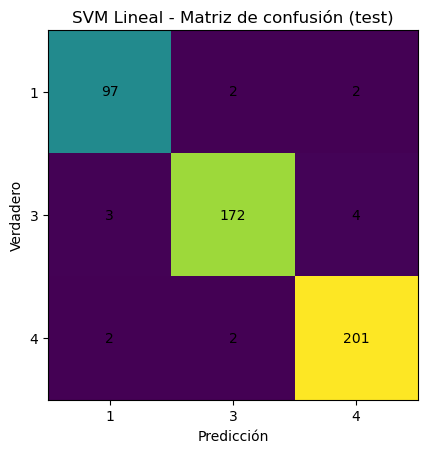

In [42]:
svm = LinearSVC(class_weight="balanced", random_state=SEED)
svm.fit(X_train, y_train)

pred_val  = svm.predict(X_val)
pred_test = svm.predict(X_test)

m_svm_val, m_svm_test = imprimir_resumen("SVM Lineal (LinearSVC)", y_val, pred_val, y_test, pred_test)
plot_confusion(y_test, pred_test, "SVM Lineal - Matriz de confusión (test)")

Se entrena un modelo de **Máquinas de Vectores de Soporte (SVM)** con kernel lineal.  
Se evalúa en validación y test, mostrando métricas y matriz de confusión.

## Comparación de modelos

In [43]:
comparacion = pd.DataFrame([
    {"modelo": "Naive Bayes Multinomial", **m_nb_test},
    {"modelo": "Regresión Logística",     **m_lr_test},
    {"modelo": "SVM Lineal (LinearSVC)",  **m_svm_test},
])

comparacion = comparacion.sort_values("f1_macro", ascending=False).reset_index(drop=True)
comparacion

,modelo,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,SVM Lineal (LinearSVC),0.969072,0.966423,0.967259,0.966802,0.969152,0.969072,0.969072
1,Regresión Logística,0.967010,0.964529,0.965397,0.964924,0.967055,0.967010,0.966993
2,Naive Bayes Multinomial,0.946392,0.935735,0.944371,0.939450,0.947932,0.946392,0.946706


Resultado: Se construye un dataframe con las métricas principales de cada modelo. Se ordena por F1-macro en el conjunto de prueba para seleccionar el mejor modelo.

## Selcción y guardado del mejor modelo

In [44]:
mejor = comparacion.iloc[0]["modelo"]
print("Mejor modelo (según F1-macro en TEST):", mejor)

model_objects = {
    "Naive Bayes Multinomial": nb,
    "Regresión Logística": lr,
    "SVM Lineal (LinearSVC)": svm,
}
best_model = model_objects[mejor]

os.makedirs("artefactos_modelo", exist_ok=True)
joblib.dump(vectorizador, "artefactos_modelo/vectorizador_tfidf.joblib")
joblib.dump(best_model,  "artefactos_modelo/mejor_modelo.joblib")
comparacion.to_csv("artefactos_modelo/metricas_test.csv", index=False)

print("Artefactos guardados en ./artefactos_modelo")

Mejor modelo (según F1-macro en TEST): SVM Lineal (LinearSVC)
Artefactos guardados en ./artefactos_modelo


Resultado: Se guarda el vectorizador TF-IDF y el mejor modelo entrenado en la carpeta artefactos_modelo/. También se exporta un CSV con las métricas finales en el conjunto de test.

## Reporte final del mejor modelo

In [45]:
y_pred_best = model_objects[mejor].predict(X_test)
print(classification_report(y_test, y_pred_best, digits=3))

              precision    recall  f1-score   support

           1      0.951     0.960     0.956       101
           3      0.977     0.961     0.969       179
           4      0.971     0.980     0.976       205

    accuracy                          0.969       485
   macro avg      0.966     0.967     0.967       485
weighted avg      0.969     0.969     0.969       485



Se genera un classification report detallado (precision, recall y F1 por clase) para el modelo seleccionado como el mejor.

## Exportación de resultados del mejor modelo

In [46]:
y_pred_final = best_model.predict(X_test)

test_resultados = test_df.copy()
test_resultados["prediccion_modelo"] = y_pred_final

ruta_salida = "resultados_test.xlsx"
test_resultados.to_excel(ruta_salida, index=False)

print(f"Archivo de resultados exportado a: {ruta_salida}")

Archivo de resultados exportado a: resultados_test.xlsx


En esta parte se generan las predicciones finales del mejor modelo seleccionado (SVM Lineal) sobre el conjunto de prueba.  
Se crea una copia del dataset de prueba y se añade la columna prediccion_modelo con las etiquetas asignadas por el modelo.  
Finalmente, los resultados son exportados a un archivo Excel, el cual se entrega como insumo para la evaluación comparativa del desempeño del modelo.